In [1]:
import pandas as pd
import numpy as np
import scipy.special 
import matplotlib.pyplot as plt
import math

 # TZ metrics

## Static route stretch

In [2]:
def import_stretch(filename):
    df = pd.read_csv(filename, names=["baseline_stretch", "audited_stretch", "respects_no_valley"])
    return df

In [3]:
def crunch_stretch(filename):
    pandas_data = import_stretch(filename)
    static_stretch = pandas_data.to_numpy()
    
    # Filter out paths with same origin and destination
    static_stretch = static_stretch[static_stretch[:,0] > 0,:]
    
    plt.scatter(static_stretch[:,0], static_stretch[:,1], alpha=.3)
    plt.title("Path lenghts combinations")
    
    stretches = static_stretch[:,1].astype(float) / static_stretch[:,0] 
    stretch_distr = np.sort(stretches)
    
    print("Measured average stretch: %f\tMeasured median stretch: %f\t Paths with valleys: %f\n" % (np.average(stretches), np.median(stretches), np.average(static_stretch[:,2])))
    
    stretch_distr = np.array([[x[0], x.shape[0]] for x in np.split(stretch_distr, np.unique(stretch_distr, return_index=True)[1])[1:]])
    stretch_distr[:,1] = stretch_distr[:,1] / float(static_stretch.shape[0])
    
    plt.figure()
    plt.xlabel("TZ stretch")
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.plot(stretch_distr[:,0], stretch_distr[:,1], '--o', alpha=.7, label="Stretch PDF")
    plt.plot(stretch_distr[:,0], np.cumsum(stretch_distr[:,1]), ':^', label="Stretch CDF")
    #plt.vlines(1.1, ymin=0, ymax=1, linestyles='dashed', colors=['green'])
    plt.legend()

Measured average stretch: 1.100412	Measured median stretch: 1.000000	 Paths with valleys: 0.015049



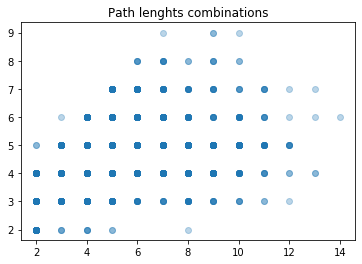

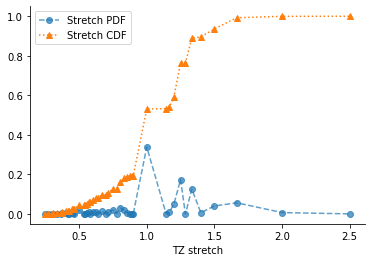

In [4]:
crunch_stretch("./simulation/data/full-GR-stretch-4000.csv")

Measured average stretch: 1.117611	Measured median stretch: 1.000000	 Paths with valleys: 0.150189



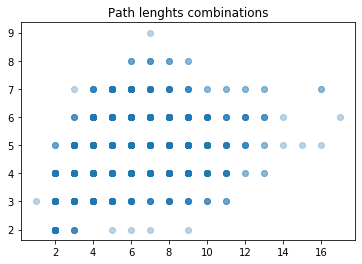

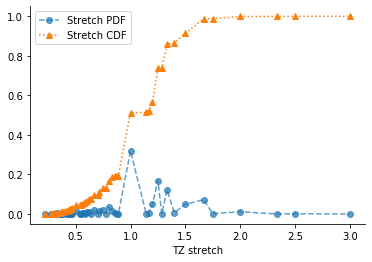

In [5]:
crunch_stretch("./simulation/data/full-GR(not-on-discovery)-stretch-4000.csv")

Measured average stretch: 1.105795	Measured median stretch: 1.000000	 Paths with valleys: 0.115520



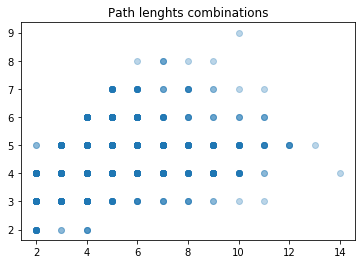

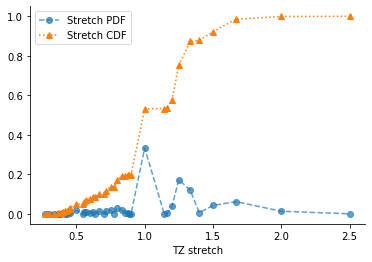

In [6]:
crunch_stretch("./simulation/data/full-stretch-2000.csv")

## Link deletion impact

An impact file contains the following columns
  - `endpoint1` The asn of the first node
  - `endpoint2` The asn of the second node
  - `degree1` The number of links (before deletion) of the 1st node
  - `degree2` The number of links (before deletion) of the 2nd node
  - `impact` The number of nodes that must send/receive updates

In [12]:
def import_impact(filename):
    df = pd.read_csv(filename, names=["endpoint1", "endpoint2", "degree1", "degree2", "impact"])
    return df

In [13]:
# Save impact to file
# link_del_impact.to_csv("./simulation/data/full-impact-2000.csv", index=False, header=False)

In [14]:
dataset_name = "full-impact-4000"

In [15]:
link_del_impact = import_impact("./simulation/data/" + dataset_name + ".csv")
link_del_impact

,endpoint1,endpoint2,degree1,degree2,impact
0,63159,3741,2,745,2
1,30421,22773,2,543,2
2,13893,209,3,1791,3
3,263722,4323,3,1487,3
4,267708,4323,2,1486,2
...,...,...,...,...,...
3995,132394,63956,7,804,7
3996,204263,51185,6,4270,6
3997,134626,4787,2,60,2
3998,204068,43061,2,79,2


In [16]:
deletion_impact = link_del_impact.to_numpy()

#### Impact statistics

In [17]:
print("The average impact is %.3f, the maximum impact is %.0f" % (deletion_impact[:,4].mean(), deletion_impact[:,4].max()))

The average impact is 21.908, the maximum impact is 13945


#### Impact by degree quotient
Here, I relate the number of updated nodes with the quotient between the maximum and the minimum degree of the endpoints  

In [18]:
abs_deg_val = np.log(np.maximum(deletion_impact[:,2:3], deletion_impact[:,3:4]))

In [19]:
degree_quotient_impact = np.concatenate([np.maximum(deletion_impact[:,2:3], deletion_impact[:,3:4])/np.minimum(deletion_impact[:,2:3], deletion_impact[:,3:4]).astype(float), deletion_impact[:,4:5]], axis=1)
degree_quotient_impact = degree_quotient_impact[np.argsort(degree_quotient_impact[:,0]),:]

In [20]:
degree_quotient_impact = np.array([[x[0,0], x[:,1].mean()] for x in np.split(degree_quotient_impact, np.unique(degree_quotient_impact[:,0], return_index=True)[1])[1:]])

In [21]:
# Delete entries without updates (y=0)
zero_impact_fraction = (degree_quotient_impact[:,1] == 0.).sum() / float(degree_quotient_impact.shape[0])
degree_quotient_impact = degree_quotient_impact[degree_quotient_impact[:,1] != 0., :]
degree_quotient_impact

array([[1.00000000e+00, 3.38596491e+00],
       [1.05000000e+00, 2.30000000e+01],
       [1.08695652e+00, 4.70000000e+01],
       ...,
       [4.10650000e+03, 2.00000000e+00],
       [4.10950000e+03, 2.00000000e+00],
       [4.11150000e+03, 2.72000000e+02]])

In [22]:
print("%.2f%% of the link deletions didn't require any update" % (zero_impact_fraction*100))

7.07% of the link deletions didn't require any update


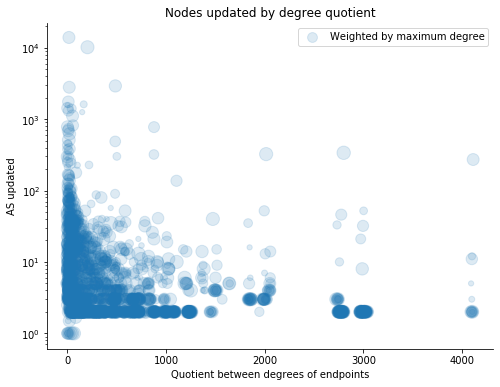

In [23]:
plt.figure(figsize=(8, 6))
plt.title("Nodes updated by degree quotient")
plt.scatter(degree_quotient_impact[:,0], degree_quotient_impact[:,1], abs_deg_val * 20, alpha=.15)
plt.yscale("log")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(["Weighted by maximum degree"])
plt.ylabel("AS updated")
plt.xlabel("Quotient between degrees of endpoints");
#plt.savefig("./figs/" + dataset_name + "-deg_quotient.svg")

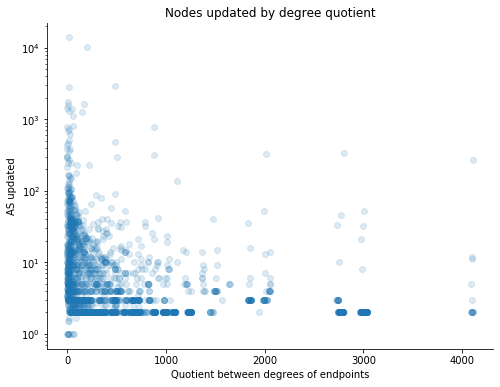

In [24]:
plt.figure(figsize=(8, 6))
plt.title("Nodes updated by degree quotient")
plt.scatter(degree_quotient_impact[:,0], degree_quotient_impact[:,1], alpha=.15)
plt.yscale("log")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.ylabel("AS updated")
plt.xlabel("Quotient between degrees of endpoints");

In [25]:
rng = []
i = 1
step = 5
for idx, x in enumerate(degree_quotient_impact[:,0]):
    if x > step * i:
        rng.append(idx)
        i += 1

In [26]:
quotient_cat_degree = np.array([[x[0,0], x[:,1].mean()] for x in np.split(degree_quotient_impact, rng)[1:]])

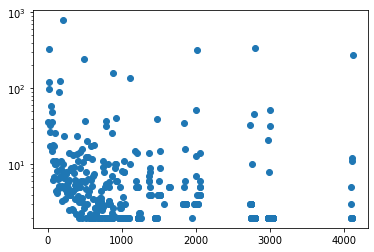

In [27]:
plt.scatter(quotient_cat_degree[:,0], quotient_cat_degree[:,1])
plt.yscale("log")

## Link deletion stretch increase

File `full-deletion-stretch-2000.csv` was obtained restarting 3 times:
 - after 1383 links deleted
 - after 1687 links deleted

In [28]:
def import_stretch_increase(filename):
    df = pd.read_csv(filename, names=["baseline_before", "audited_before", "baseline_after", "audited_after"])
    return df

In [29]:
pd_deletion_stretch = import_stretch_increase("./simulation/data/full-deletion-stretch-2000.csv")
pd_deletion_stretch

,baseline_before,audited_before,baseline_after,audited_after
0,2,4,3,4
1,2,3,3,3
2,2,4,3,4
3,2,2,3,5
4,2,4,3,4
...,...,...,...,...
1995,2,2,3,6
1996,2,3,3,3
1997,2,4,3,4
1998,2,2,4,4


In [30]:
deletion_stretch = pd_deletion_stretch.to_numpy().astype(float)

In [31]:
# Measure hops and not nodes
deletion_stretch = deletion_stretch - 1

In [32]:
stretch_before = deletion_stretch[:,1] / deletion_stretch[:,0]
stretch_after = deletion_stretch[:,3] / deletion_stretch[:,2]

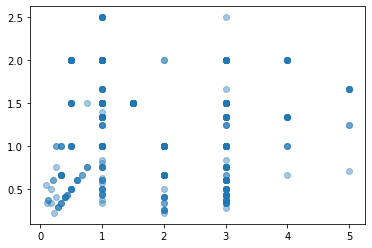

In [33]:
plt.scatter(stretch_before, stretch_after, alpha=.4)

In [34]:
stretch_before[np.nonzero(stretch_before % 1 != 0)]

array([0.5       , 0.5       , 1.5       , 1.5       , 1.5       ,
       0.5       , 0.5       , 0.75      , 0.5       , 1.5       ,
       0.66666667, 0.25      , 1.5       , 0.33333333, 0.5       ,
       0.42857143, 1.5       , 0.66666667, 0.75      , 1.5       ,
       0.6       , 0.5       , 0.33333333, 1.5       , 0.6       ,
       1.5       , 0.4       , 1.5       , 0.4       , 0.16666667,
       0.5       , 1.5       , 0.5       , 0.5       , 0.33333333,
       0.28571429, 0.5       , 0.33333333, 1.5       , 0.4       ,
       0.4       , 0.5       , 0.33333333, 1.5       , 1.5       ,
       0.75      , 0.33333333, 0.4       , 0.6       , 0.28571429,
       0.25      , 1.5       , 0.5       , 0.5       , 0.5       ,
       0.33333333, 0.75      , 0.125     , 0.11111111, 0.5       ,
       0.5       , 0.5       , 1.5       , 0.5       , 1.5       ,
       0.6       , 0.5       , 1.5       , 0.125     , 0.25      ,
       1.5       , 0.33333333, 0.42857143, 0.5       , 0.5    

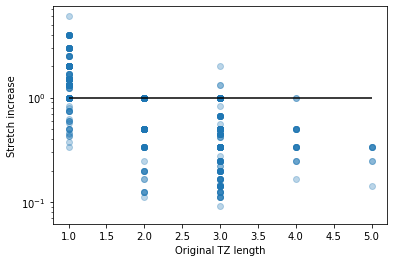

In [35]:
plt.scatter(deletion_stretch[:,1], stretch_after / stretch_before, alpha=.3)
plt.xlabel("Original TZ length")
plt.ylabel("Stretch increase")
plt.yscale("log")
plt.hlines(1, xmin=1, xmax=5);

## Effect of multiple edge deletions on stretch

Starting from `cumulative-deletions-3x.1.csv` the first stretch measurement is performed **before** deleting any links

In [7]:
def import_cumulative_deletions(filename):
    df = pd.read_csv(filename, names=["baseline_stretch", "audited_stretch", "respects_no_valley"])
    return df

In [8]:
def stretch_statistics_by_round(round_data):
    return ((round_data[:,1]/round_data[:,0]).mean(), round_data[:,2].mean())

In [9]:
def crunch_cumulative_deletions(filename):
    cumul_deletions = import_cumulative_deletions(filename)
    cumul_deletions = cumul_deletions.to_numpy()
    
    # Find lines that mark the beginning of a round (with the form [-round_num, -round_num, -round_num])
    cumul_by_round = np.split(cumul_deletions.astype(float), np.nonzero(np.sum(cumul_deletions, axis=1) < 1)[0])[1:]
    
    # Delete the markers
    cumul_by_round = [rd[1:] for rd in cumul_by_round]
    
    return [stretch_statistics_by_round(r) for r in cumul_by_round], cumul_by_round[0].shape[0]

In [39]:
cumul_statistics_4_05, round_samples_4_05 = crunch_cumulative_deletions("./simulation/data/cumulative-deletions-GR-4x.005.csv")
cumul_statistics_8_05, round_samples_8_05 = crunch_cumulative_deletions("./simulation/data/cumulative-deletions-8x.05.csv")
cumul_statistics_9_05, round_samples_9_05 = crunch_cumulative_deletions("./simulation/data/cumulative-deletions-12x.05-(3).csv")
cumul_statistics_12_05, round_samples_12_05 = crunch_cumulative_deletions("./simulation/data/cumulative-deletions-12x.05.csv")
cumul_statistics_10_05, round_samples_10_05 = crunch_cumulative_deletions("./simulation/data/cumulative-deletions-12x.05-(2).csv")

In [40]:
round_samples_8_05, round_samples_9_05, round_samples_12_05, round_samples_10_05

(794, 1193, 1198, 1989)

In [41]:
cumul_statistics_8_05, cumul_statistics_9_05, cumul_statistics_12_05, cumul_statistics_10_05

([(1.11306469908485, 0.10831234256926953),
  (1.1085060040462051, 0.11180904522613065),
  (1.1407932468375506, 0.1189873417721519),
  (1.1492217051619849, 0.15374841168996187),
  (1.1445051830255912, 0.125),
  (1.1606497401484548, 0.13881748071979436),
  (1.1771827009374902, 0.17113665389527458),
  (1.1649907947449993, 0.17335058214747737)],
 [(1.1073650981132122, 0.10645431684828165),
  (1.120356592276123, 0.11148365465213747),
  (1.1597444560859196, 0.12699747687132043),
  (1.1615009395865818, 0.12510495382031905),
  (1.1454369673119673, 0.14104729729729729),
  (1.163419496340077, 0.12809564474807855),
  (1.1788108197546974, 0.14710884353741496),
  (1.1889122069488338, 0.1567291311754685),
  (1.1864444171242796, 0.153184165232358),
  (1.1937747394573532, 0.15752625437572929)],
 [(1.0871501295958725, 0.11268781302170283),
  (1.119884124078755, 0.12416107382550336),
  (1.1439018371960537, 0.11399832355406538),
  (1.1426329165340154, 0.13609467455621302),
  (1.146667894823111, 0.1382527

In [42]:
deletion_proportion = .05
full_edges_num = 466982

In [43]:
deleted_edges_by_round = [100 * deletion_proportion * (math.pow(1 - deletion_proportion, k)-1) / float(-deletion_proportion) for k in range(0, 13)]

In [44]:
deleted_edges_by_round

[-0.0,
 5.000000000000004,
 9.750000000000002,
 14.26250000000001,
 18.549375000000012,
 22.621906250000023,
 26.490810937500022,
 30.166270390625026,
 33.65795687109377,
 36.97505902753909,
 40.12630607616213,
 43.11999077235403,
 45.96399123373633]

Text(0, 0.5, 'Average stretch')

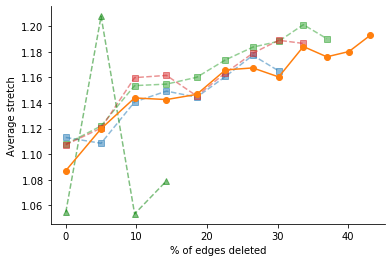

In [50]:
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot(deleted_edges_by_round[:8], [c[0] for c in cumul_statistics_8_05], '--s', alpha=.5)
plt.plot(deleted_edges_by_round[:12], [c[0] for c in cumul_statistics_12_05], '-o', zorder=10)
plt.plot(deleted_edges_by_round[:10], [c[0] for c in cumul_statistics_10_05[:10]], '--s', alpha=.5)
plt.plot(deleted_edges_by_round[:9], [c[0] for c in cumul_statistics_9_05[:9]], '--s', alpha=.5)
plt.plot(deleted_edges_by_round[:4], [c[0] for c in cumul_statistics_4_05[:4]], '--^', alpha=.5, color="green", zorder=5)
plt.xlabel("% of edges deleted")
plt.ylabel("Average stretch")

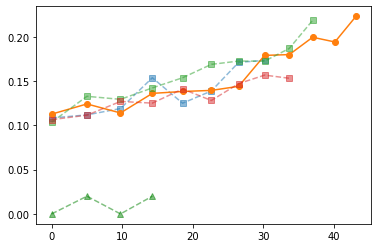

In [51]:
plt.plot(deleted_edges_by_round[:8], [c[1] for c in cumul_statistics_8_05], '--s', alpha=.5)
plt.plot(deleted_edges_by_round[:12], [c[1] for c in cumul_statistics_12_05], '-o')
plt.plot(deleted_edges_by_round[:10], [c[1] for c in cumul_statistics_10_05[:10]], '--s', alpha=.5)
plt.plot(deleted_edges_by_round[:9], [c[1] for c in cumul_statistics_9_05[:9]], '--s', alpha=.5)
plt.plot(deleted_edges_by_round[:4], [c[1] for c in cumul_statistics_4_05[:4]], '--^', color="green", alpha=.5)